# Approximate Mass-Sheet Transforms
This notebooks profies an assessment of how we can constrain lens model families with imaging data and kinematics.




This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
- fastell4py (only when using the PEMD model) (https://github.com/sibirrer/fastell4py), based on the original fastell fortran code (by Barkana)

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from pylab import rc

rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

np.random.seed(42)

# import lenstronomy modules
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
from  lenstronomy.Util import param_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

## simulation choices

In [2]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

    
# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'
kernel_size = 91
#kernel_cut = kernel_util.cut_psf(kernel, kernel_size)

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
# generate the psf variables

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
#kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
psf_class = PSF(**kwargs_psf)

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in log10


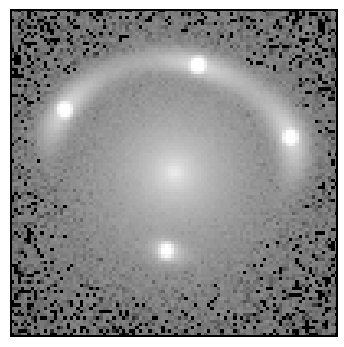

In [3]:
# lensing quantities
kwargs_shear = {'gamma1': 0.05, 'gamma2': -0.02}  # shear values to the source plane
kwargs_pemd = {'theta_E': 1.66, 'gamma': 1.98, 'center_x': 0.0, 'center_y': 0.0, 'e1': -0.2, 'e2': 0.05}  # parameters of the deflector lens model
kwargs_core = {'sigma0': 0.0, 'r_core': 10, 'center_x': 0, 'center_y': 0}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['PEMD', 'SHEAR', 'CORED_DENSITY_2']
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_core]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.
source_y = 0.25


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 2000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
# for this exercise we do not include lens light in the imaging model and fix it for the kinematics to be a Hernquist profile with a half light radius parameter

r_eff = 0.8
lens_light_model_list = ['HERNQUIST']
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
kwargs_hernquist = {'amp': 4000, 'Rs': r_eff*0.551, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_hernquist]
#phi_G, q = 0.9, 0.9
#e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
#kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.4, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
#lens_light_model_list = ['SERSIC_ELLIPSE']
#kwargs_lens_light = [kwargs_sersic_lens]
#lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
#plt.savefig('/Users/sibirrer/Science/Publications/MST_H0/mock_lens_pl.pdf')


plt.show()

## time delays
time delays are defined in **lenstronomy** as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

In [4]:
from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
print(dt_days)
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [2, 2, 2]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [-1.67758425  1.77485215  0.35979056 -0.1175635 ] [ 0.96581545  0.53556011  1.63845255 -1.19307306] are:  [-158.14036842 -146.45926622 -130.55092829  -64.22959915]
[11.6811022  27.58944013 93.91076927]
the measured relative delays are:  [12.3776747  28.15608732 92.03772958]


## kinematics
Kinematics can provide important complementary information about the lens to constrain cosmography

In [5]:
# observational conditions of the spectroscopic campagne
R_slit = 1. # slit length in arcsec
dR_slit = 1.  # slit width in arcsec
psf_fwhm = 0.7

kwargs_aperture = {'aperture_type': 'slit', 'length': R_slit, 'width': dR_slit, 'center_ra': 0.05, 'center_dec': 0, 'angle': 0}
anisotropy_model = 'OM' #  'isotropic'
aperture_type = 'slit'

kwargs_galkin_numerics = {#'sampling_number': 10000, # numerical ray-shooting, should converge -> infinity
                          'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                           'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals

r_ani = 1.
r_eff = 0.2
kwargs_anisotropy = {'r_ani': 1}
kwargs_seeing = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}

from lenstronomy.Analysis.kinematics_api import KinematicsAPI
kin_api = KinematicsAPI(z_lens, z_source, kwargs_model, cosmo=cosmo, lens_model_kinematics_bool=[True, False, True],
                 light_model_kinematics_bool=[True], kwargs_aperture=kwargs_aperture, kwargs_seeing=kwargs_seeing,
                       anisotropy_model=anisotropy_model, Hernquist_approx=True, kwargs_numerics_galkin=kwargs_galkin_numerics,
                       sampling_number=40000)

vel_disp = kin_api.velocity_dispersion(kwargs_lens, kwargs_lens_light, kwargs_anisotropy,
                                    r_eff=r_eff, theta_E=None, kappa_ext=0)
print(vel_disp, 'velocity dispersion in km/s')

266.5356232624655 velocity dispersion in km/s


## Model and parameter choices

In [6]:
lens_model_list_fit = ['PEMD', 'SHEAR', 'CORED_DENSITY_2_MST']

kwargs_model_fit = {'lens_model_list': lens_model_list_fit, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
#kwargs_lens_init.append({'theta_E': 1.6, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0, 'e2': 0.})
kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
#kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})
kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})

#fixed_lens.append({'r_core': kwargs_core['r_core']})
fixed_lens.append({})
kwargs_lens_init.append({'lambda_approx': 1 - kwargs_core['sigma0'], 'r_core': kwargs_core['r_core'], 'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'lambda_approx': 0.1, 'r_core': 10, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'lambda_approx': 0, 'r_core': 0, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'lambda_approx': 2, 'r_core': 20, 'center_x': 10, 'center_y': 10})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append(kwargs_hernquist)
kwargs_lens_light_init.append(kwargs_hernquist)
kwargs_lens_light_sigma.append({'Rs': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'Rs': 0, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'Rs': 10, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt': 10000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}


In [7]:

# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'joint_lens_with_lens': [[0, 2, ['center_x', 'center_y']]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                              }

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'time_delay_likelihood': True,
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model_fit, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 100}],
        ['MCMC', {'n_burn': 1000, 'n_run': 2000, 'walkerRatio': 10, 'sigma_scale': .2}]
]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0003845194978709 reduced X^2 of best position
-4991.418560034627 logL
9979 effective number of data points
[{'theta_E': 1.6514269001988726, 'gamma': 1.9936371178591, 'e1': -0.19708854181605387, 'e2': 0.04905328432288359, 'center_x': 0.00038733455057499974, 'center_y': 0.0031696881123457906}, {'gamma1': 0.05315112405806557, 'gamma2': -0.02087072136453355, 'ra_0': 0, 'dec_0': 0}, {'lambda_approx': 1.3235990225532417, 'r_core': 10.867341562551797, 'center_x': 0.0, 'center_y': 0.0}] lens result
[{'amp': 1, 'R_sersic': 0.1001106009396199, 'n_sersic': 1.0160344444565843, 'e1': 0.058393907885834026, 'e2': 0.09325605415410353, 'center_x': 0.0004445906471670369, 'center_y': 0.2521902783159697}] source result
[{'amp': 4000, 'Rs': 0.4408000000000001, 'center_x': 0, 'center_y': 0}] lens light result
[{'ra_image': array([-1.67752677,  1.77472765,  0.35961717, -0.11731359]), 'dec_image': array([ 0.96582501,  0.53553201,  1.63849326, 

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [3:35:24<00:00,  3.84s/it]  

Computing the MCMC...
Number of walkers =  180
Burn-in iterations:  1000
Sampling iterations (in current run): 3000
12930.759498596191 time taken for MCMC sampling
13649.830021858215 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


## analyse model output

-0.9983857513475588 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9983857513475587


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:547: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:517: RuntimeWarning: invalid 

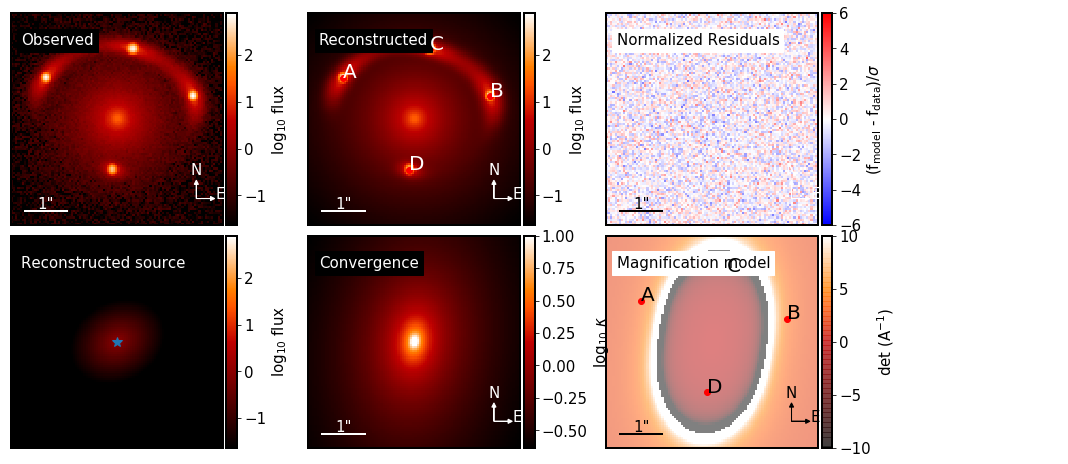

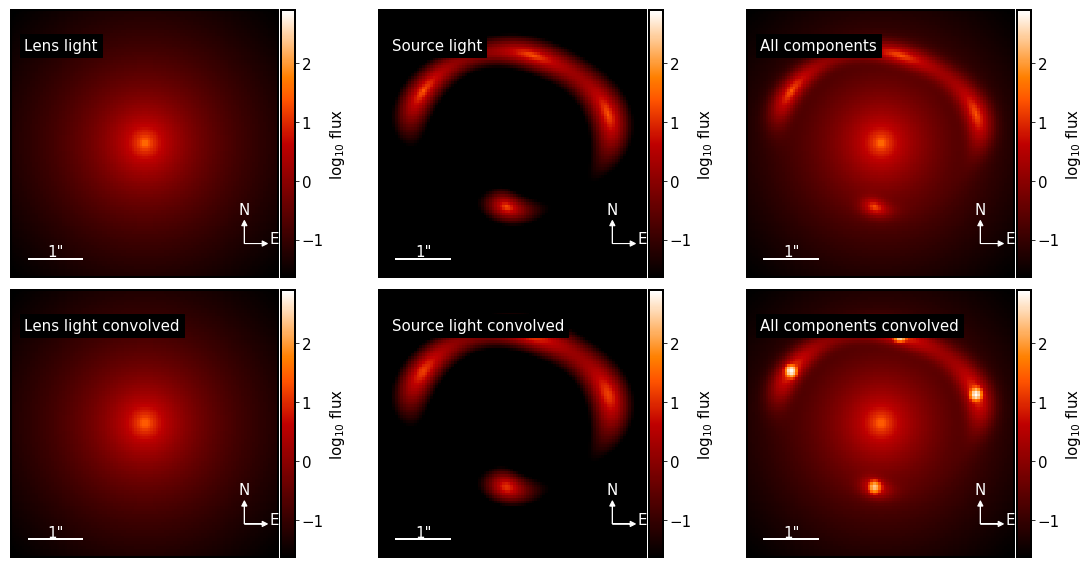

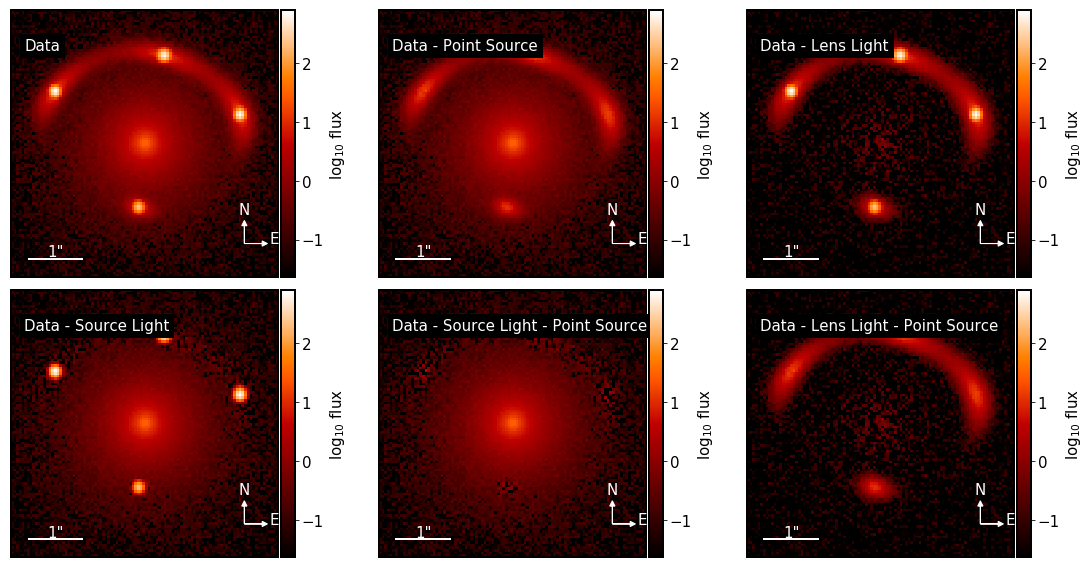

In [8]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model_fit, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()


In [9]:
#or i in range(len(chain_list)):
#    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model_fit, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
labels_new = [r"$\gamma_{\rm pl}$", r"$\phi_{ext}$", r"$\gamma_{ext}$", r'$\theta_E / \lambda_{\rm c}$', r'$\lambda_{\rm c}D_{\Delta t}$', r"$\lambda_{\rm c}$", r'$R_{\rm c}$']
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_result['kwargs_special']['D_dt']
    #fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    #delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma = kwargs_result['kwargs_lens'][0]['gamma']
    gamma1, gamma2 = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    phi_ext, gamma_ext = param_util.shear_cartesian2polar(gamma1, gamma2)
    lambda_approx = kwargs_result['kwargs_lens'][2]['lambda_approx']
    r_core = kwargs_result['kwargs_lens'][2]['r_core']
    theta_E = kwargs_result['kwargs_lens'][0]['theta_E']
    mcmc_new_list.append([gamma, phi_ext, gamma_ext, theta_E, D_dt, lambda_approx, r_core])



number of non-linear parameters in the MCMC process:  18
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'lambda_approx_lens2', 'r_core_lens2', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  360000


3329.6653609254795


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


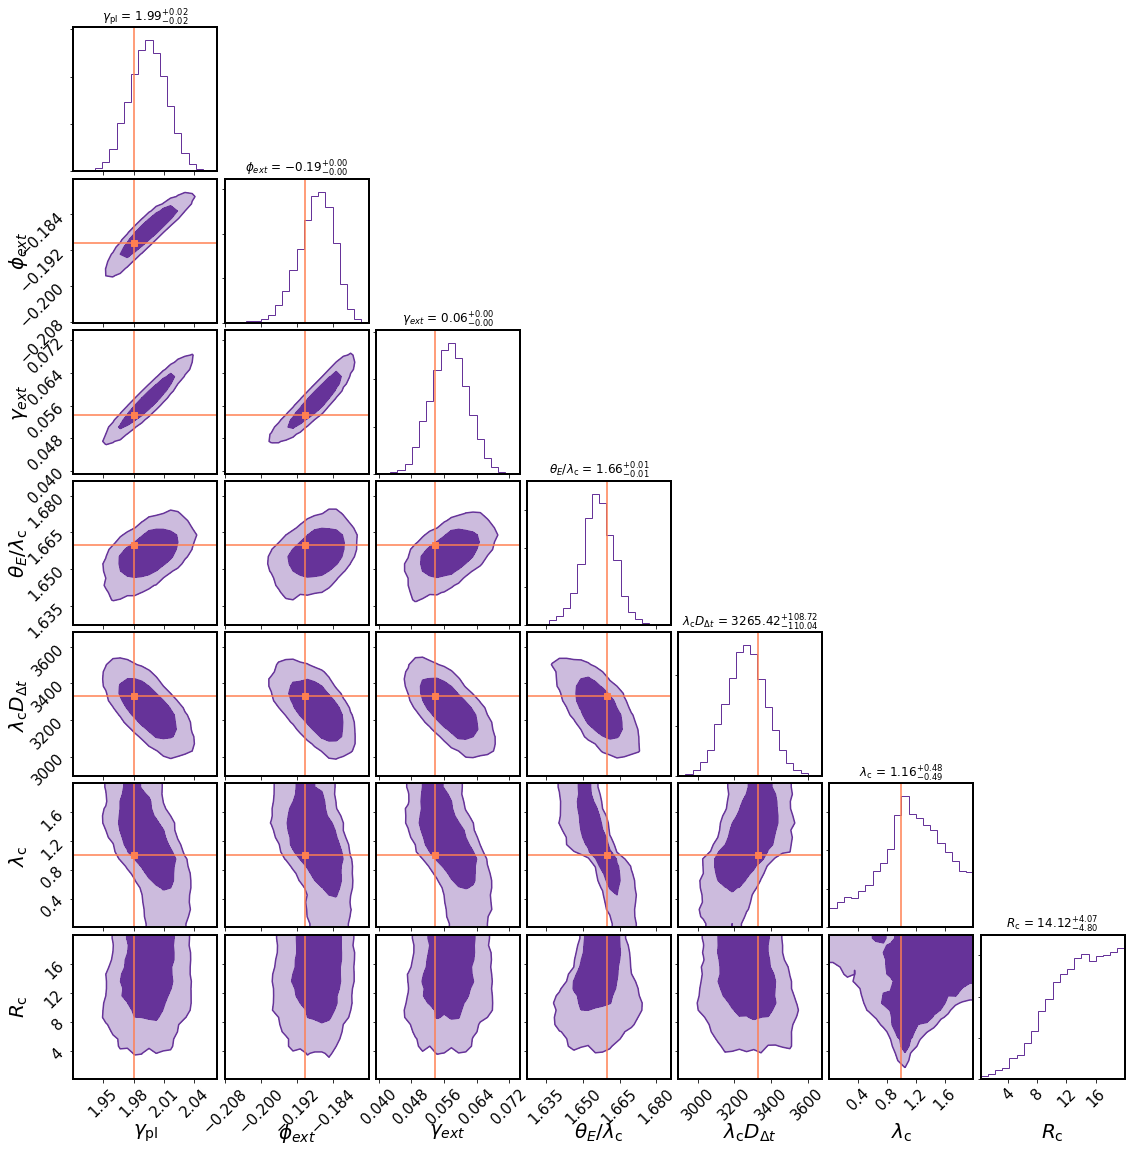

In [16]:
# here we just re-compute the true Ddt that needs to be recovered
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
labels_new = [r"$\gamma_{\rm pl}$", r"$\phi_{ext}$", r"$\gamma_{ext}$", r'$\theta_E / \lambda_{\rm c}$', r'$\lambda_{\rm c}D_{\Delta t}$', r"$\lambda_{\rm c}$", r'$R_{\rm c}$']


lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
print(lensCosmo.ddt)

alpha = 0.8
                 
kwargs_corner = {'bins': 20, 'plot_datapoints': False, 'show_titles': True,  
                 'label_kwargs': dict(fontsize=20), 'smooth': 0.5, 'levels': [0.68,0.95],
                'fill_contours': True, 'alpha': alpha}

phi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_shear['gamma1'], kwargs_shear['gamma2'])
truths = [kwargs_pemd['gamma'], phi_ext, gamma_ext, kwargs_pemd['theta_E'], lensCosmo.ddt, 1, -1]

fig = corner.corner(mcmc_new_list,
                    labels=labels_new,
                    truths=truths,
                    color='rebeccapurple',
                    truth_color='coral', **kwargs_corner)

#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/lambda_int_posteriors.pdf')
fig.show()

## Trend in core radius and allowed density
Here we further investigate the core size and lambda parameter constraints that can be provided by the imaging mock example. We aim to translate a prior in core size and density space into an allowed MST

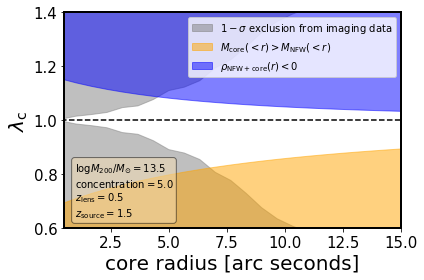

In [11]:
mcmc_new_list = np.array(mcmc_new_list)
r_core_posterior = mcmc_new_list[:, 6]
lambda_posterior = mcmc_new_list[:, 5]

r_list = np.linspace(0, 20, 31)
lambda_sigma_list = []
for i in range(len(r_list) - 1):
    lambda_select = lambda_posterior[(r_core_posterior > r_list[i]) & (r_core_posterior < r_list[i+1])]
    lambda_sigma = np.std(lambda_select)
    lambda_sigma_list.append(lambda_sigma)
lambda_sigma_list = np.array(lambda_sigma_list)
r_array = (r_list[1:] + r_list[0:-1]) / 2
#mass_3d_core = lambda_mst * r_core**2 * np.pi
#plt.plot(r_array, lambda_sigma_list)
plt.fill_between(r_array, lambda_sigma_list+1, 2, alpha=0.5, color='grey', 
                 label=r'$1-\sigma$ exclusion from imaging data')
plt.fill_between(r_array, -lambda_sigma_list+1, 0, alpha=0.5, color='grey')

# and now we look at a typical NFW profile in projection in the convergence profile

M200 = 10**13.5
c = 5
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.Profiles.nfw import NFW
nfw = NFW()
lensCosmo = LensCosmo(z_lens=0.6, z_source=1.5, cosmo=cosmo)
Rs_angle, alpha_Rs =lensCosmo.nfw_physical2angle(M200, c)
kwargs_nfw = {'alpha_Rs': alpha_Rs, 'Rs': Rs_angle}
nfw_lens = LensModel(lens_model_list=['NFW'])

kappa_r_nfw = nfw_lens.kappa(r_array, 0, [kwargs_nfw])

mass_3d_nfw = nfw.mass_3d_lens(r_array, **kwargs_nfw)
lambda_max_nfw = 1 - mass_3d_nfw / r_array**2 / np.pi
plt.fill_between(r_array, lambda_max_nfw, 0, alpha=0.5, color='orange', label=r'$M_{\rm core}(<r) > M_{\rm NFW}(<r)$')

density_nfw = nfw.density_lens(r_array, **kwargs_nfw)
kappa_max = density_nfw * r_array
plt.fill_between(r_array, 1 + kappa_max, 2, alpha=0.5, color='blue', label=r'$\rho_{\rm NFW + core}(r) < 0$')




kwargs_sis = [{'theta_E': 1}]
sis = LensModel(lens_model_list=['SIS'])
kappa_r_sis = sis.kappa(r_array, 0, kwargs_sis)
mass_3d_sis = None
plt.legend()
plt.xlabel('core radius [arc seconds]', fontsize=20)
plt.ylabel(r'$\lambda_{\rm c}$', fontsize=20)
plt.ylim([0.6, 1.4])
plt.xlim([0.5, 15])


textstr = '\n'.join((
    r'$\log M_{200} /M_{\odot}=%.1f$' % (np.log10(M200), ),
    r'${\rm concentration}=%.1f$' % (c, ),
    r'$z_{\rm lens}=%.1f$' % (z_lens, ),
    r'$z_{\rm source}=%.1f$' % (z_source)))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
plt.text(0.05, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
plt.plot(r_array, np.ones_like(r_array), 'k--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/lambda_int_bounds.pdf')
plt.show()


## PL + density core profiles in 2d and 3d 
Here we illustrate different choices of $\lambda_{\rm approx}$ with a density core and how they alter the projected 2d density and the radial 3d density of the matter distribution.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


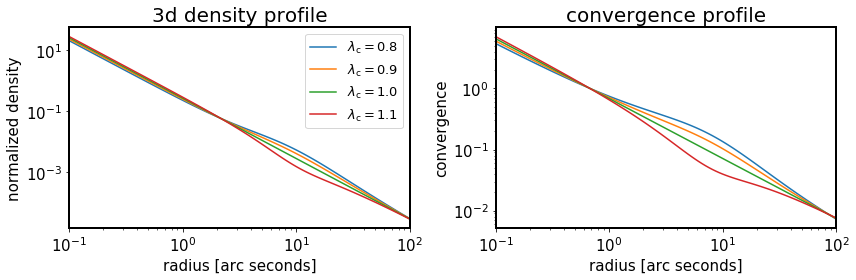

In [23]:
from lenstronomy.LensModel.single_plane import SinglePlane
sp = SinglePlane(lens_model_list=lens_model_list)


f, axes = plt.subplots(1, 2, figsize=(12, 4))
r = np.logspace(start=-1, stop=2, num=100)
kwargs_lens_plot = copy.deepcopy(kwargs_lens)
kwargs_lens_plot[2]['r_core'] = 8
lambda_list = np.linspace(0.8, 1.1, 4)

for lambda_i in lambda_list:
    
    kwargs_lens_plot[0]['theta_E'] = kwargs_lens[0]['theta_E'] * lambda_i
    sigma0 = 1 - lambda_i
    kwargs_lens_plot[2]['sigma0'] = sigma0
    rho_r = sp.density(r, kwargs_lens_plot, bool_list=[True, False, True])
    axes[0].loglog(r, rho_r, label=r'$\lambda_{\rm c} = $' + str(lambda_i))

    f_xx, f_xy, f_yx, f_yy = sp.hessian(r, 0, kwargs_lens_plot, k=[True, False, True])
    kappa_r = 1./2 * (f_xx + f_yy)
    axes[1].loglog(r, kappa_r, label=lambda_i)
    
axes[0].set_title('3d density profile', fontsize=20)
axes[0].legend(fontsize=13)
axes[0].set_xlim([0.1, 100])
axes[1].set_xlim([0.1, 100])
axes[0].set_xlabel('radius [arc seconds]', fontsize=15)
axes[0].set_ylabel('normalized density', fontsize=15)
axes[1].set_xlabel('radius [arc seconds]', fontsize=15)
axes[1].set_title('convergence profile', fontsize=20)
axes[1].set_ylabel('convergence', fontsize=15)
#plt.legend()

f.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/pl_mst_profile.pdf')
f.show()

## velocity dispersion dependence
Here we compute the scaling of the velocity dispersion with $\lambda_{\rm approx}$

In [13]:

def velocity_dependence(kwargs_lens, lambda_approx_list, r_core):

    kwargs_lens_result = copy.deepcopy(kwargs_lens)

    vel_disp_list = []

    kwargs_lens_kin = copy.deepcopy(kwargs_lens)
    kwargs_lens_kin[2]['sigma0'] = 0
    kwargs_lens_kin[2]['r_core'] = r_core

    vel_disp_0 = kin_api.velocity_dispersion(kwargs_lens_kin, kwargs_lens_light, kwargs_anisotropy, r_eff=r_eff, theta_E=None,)


    for lambda_approx in lambda_approx_list:
        sigma0 = 1 - lambda_approx
        kappa_ext = 0
        kwargs_lens_kin = copy.deepcopy(kwargs_lens)
        #del kwargs_lens_kin[2]['lambda_approx']
        kwargs_lens_kin[2]['sigma0'] = sigma0
        kwargs_lens_kin[2]['r_core'] = r_core
        kwargs_lens_kin[0]['theta_E'] = kwargs_lens[0]['theta_E'] * lambda_approx

        vel_disp = kin_api.velocity_dispersion(kwargs_lens_kin, kwargs_lens_light, kwargs_anisotropy, r_eff=r_eff, theta_E=None, kappa_ext=kappa_ext)
        vel_disp_list.append(vel_disp)
    return np.array(vel_disp_list), vel_disp_0



In [17]:
lambda_approx_list = np.linspace(0.6, 1.4, 20)
r_core_list = [0.1, 5, 10]
vel_disp_list_r = []
vel_disp_0_r = []
for r_core in r_core_list:
    vel_disp_list, vel_disp_0 = velocity_dependence(kwargs_lens, lambda_approx_list, r_core)
    vel_disp_list_r.append(vel_disp_list)
    vel_disp_0_r.append(vel_disp_0)
    print(r_core)

0.1
5
10


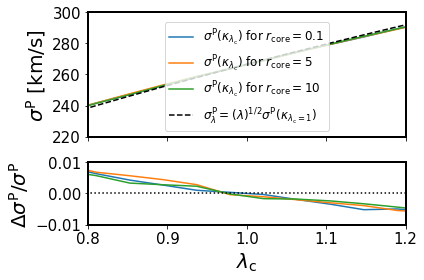

In [18]:
f, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 2]}, sharex=True)

for i in range(len(r_core_list)):
    vel_disp_list = vel_disp_list_r[i]
    vel_disp_0 = vel_disp_0_r[i]

    axes[0].plot(lambda_approx_list, vel_disp_list, label=r'$\sigma^{\rm P}(\kappa_{\lambda_{\rm c}})$ for $r_{\rm core} =$'+str(r_core_list[i]))
axes[0].plot(lambda_approx_list, vel_disp_0*np.sqrt(lambda_approx_list), 'k--', label=r"$\sigma_{\lambda}^{\rm P} = (\lambda)^{1/2} \sigma^{\rm P}(\kappa_{\lambda_{\rm c} = 1})$")
axes[0].set_ylim([220, 300])
axes[0].set_ylabel(r'$\sigma^{\rm P}$ [km/s]', fontsize=20)
axes[0].legend(fontsize=12)
    
for i in range(len(r_core_list)):
    vel_disp_list = vel_disp_list_r[i]
    vel_disp_0 = vel_disp_0_r[i]

    axes[1].plot(lambda_approx_list, (vel_disp_list - vel_disp_0*np.sqrt(lambda_approx_list)) / vel_disp_list , label=r'$\sigma^{\rm P}(\kappa_{\lambda_{\rm c}})$ for $r_{\rm core} =$'+str(r_core_list[i]))
axes[1].set_ylabel(r'$\Delta \sigma^{\rm P} / \sigma^{\rm P}$', fontsize=20)
axes[1].plot([0, 2], [0, 0], ':k')
axes[1].set_ylim([-0.01, 0.01])
plt.xlim([0.8, 1.2])
plt.subplots_adjust(hspace = -0.2)
plt.xlabel(r'$\lambda_{\rm c}$', fontsize=20)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/kinematics_mst.pdf')
plt.show()



/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:114: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


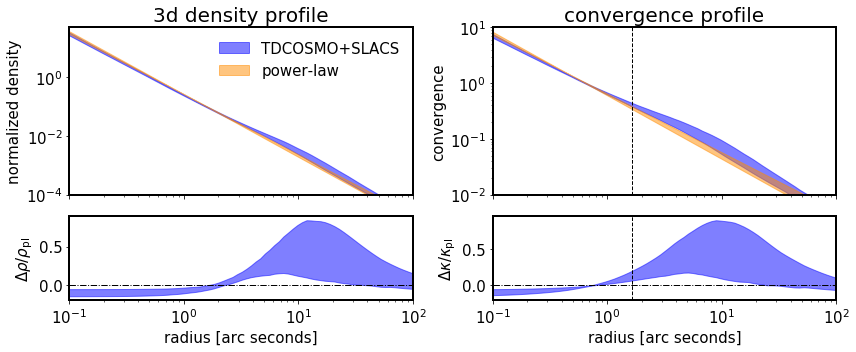

In [51]:
# plot profile with uncertainty in parameter

# transparency
alpha_transparent = 0.5
# make plots with shapes
lambda_int_mean, lambda_int_sigma = 0.91, 0.045  # post-unblinding adjustment to match the TDCOSMO+SLACS+IFU inference

# chose core radius
R_c_low = 3
R_c_high = 10

# power-law slope
gamma_mean, gamma_sigma = 2.10, 0.05  # SLACS population mean and error on the mean (approximately for illustration)

mst_shape_kappa = []
mst_shape_r = []

pl_shape_kappa = []
pl_shape_r = []

r_bins = np.logspace(-2, 2, 100)

for i in range(100):
    lambda_i = np.random.normal(lambda_int_mean, lambda_int_sigma)
    gamma_i = np.random.normal(gamma_mean, gamma_sigma)
    R_c_i = np.random.uniform(low=R_c_low, high=R_c_high)
    kwargs_lens_plot[0]['gamma'] = gamma_i
    kwargs_lens_plot[0]['theta_E'] = kwargs_lens[0]['theta_E'] * lambda_i
    sigma0 = 1 - lambda_i
    kwargs_lens_plot[2]['r_core'] = R_c_i
    kwargs_lens_plot[2]['sigma0'] = sigma0
    rho_r = sp.density(r_bins, kwargs_lens_plot, bool_list=[True, False, True])
    f_xx, f_xy, f_yx, f_yy = sp.hessian(r_bins, 0, kwargs_lens_plot, k=[True, False, True])
    kappa_r = 1./2 * (f_xx + f_yy)
    mst_shape_r.append(rho_r)
    mst_shape_kappa.append(kappa_r)
    
    kwargs_lens_plot[0]['theta_E'] = kwargs_lens[0]['theta_E']
    kwargs_lens_plot[2]['sigma0'] = 0
    
    rho_r = sp.density(r_bins, kwargs_lens_plot, bool_list=[True, False, True])
    f_xx, f_xy, f_yx, f_yy = sp.hessian(r_bins, 0, kwargs_lens_plot, k=[True, False, True])
    kappa_r = 1./2 * (f_xx + f_yy)
    pl_shape_r.append(rho_r)
    pl_shape_kappa.append(kappa_r)
    
    
mst_shape_kappa = np.array(mst_shape_kappa)
mst_shape_r = np.array(mst_shape_r)
pl_shape_kappa = np.array(pl_shape_kappa)
pl_shape_r = np.array(pl_shape_r)


f, axes = plt.subplots(2, 2, gridspec_kw={'height_ratios': [4, 2]}, sharex=True, figsize=(12, 5))
#f, axes = plt.subplots(1, 2, figsize=(12, 4))


ax = axes[0, 0]
interval = np.percentile(mst_shape_r, q=[16, 84], axis=0)
ax.fill_between(r_bins, interval[0], interval[1], color='blue', alpha=alpha_transparent, label='TDCOSMO+SLACS')

interval = np.percentile(pl_shape_r, q=[16, 84], axis=0)
ax.fill_between(r_bins, interval[0], interval[1], color='darkorange', alpha=alpha_transparent, label='power-law')
ax.legend(frameon=False, fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('3d density profile', fontsize=20)
#axes[0].legend(fontsize=13)
ax.set_ylim([0.0001, 50])
ax.set_xlim([0.1, 100])
ax.set_ylabel('normalized density', fontsize=15)


interval = np.percentile((mst_shape_r- pl_shape_r)/pl_shape_r, q=[16, 84], axis=0)
axes[1, 0].fill_between(r_bins, interval[0], interval[1], color='blue', alpha=alpha_transparent)
axes[1, 0].set_xlabel('radius [arc seconds]', fontsize=15)
axes[1, 0].axhline(0, linestyle='-.', color='k', linewidth=1)
axes[1, 0].set_ylabel(r'$\Delta\rho/\rho_{\rm pl}$', fontsize=15)



ax = axes[0, 1]
interval = np.percentile(mst_shape_kappa, q=[16, 84], axis=0)
ax.fill_between(r_bins, interval[0], interval[1], color='blue', alpha=0.5, label='MST')
ax.axvline(x=theta_E, linestyle='--', color='k', linewidth=1)

interval = np.percentile(pl_shape_kappa, q=[16, 84], axis=0)
ax.fill_between(r_bins, interval[0], interval[1], color='darkorange', alpha=0.5, label='power-law')

ax.set_xscale('log')
ax.set_yscale('log')
    
#ax.set_xlim(0.1, 2.)
#ax.set_ylim(1e-2, 1e1)

ax.set_ylim([0.01, 10])
ax.set_xlim([0.1, 100])
ax.set_title('convergence profile', fontsize=20)
ax.set_ylabel('convergence', fontsize=15)

interval = np.percentile((mst_shape_kappa- pl_shape_kappa)/pl_shape_kappa, q=[16, 84], axis=0)
axes[1, 1].fill_between(r_bins, interval[0], interval[1], color='blue', alpha=alpha_transparent)
axes[1, 1].axhline(0, linestyle='-.', color='k', linewidth=1)
axes[1, 1].axvline(x=theta_E, linestyle='--', color='k', linewidth=1)
axes[1, 1].set_xlabel('radius [arc seconds]', fontsize=15)
axes[1, 1].set_ylabel(r'$\Delta\kappa/\kappa_{\rm pl}$', fontsize=15)

#plt.legend()


f.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/pl_mst_profile_result.pdf')
f.show()


# delta rho/rho panels

# label
# value and uncertainties